In [1]:
import os, sys
import warnings
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import mean_absolute_error

In [2]:
import CONFIG
from datapreparation.preparation_functions import processing_data, read_download_preprocessed_data
from datapreparation.adaptive_sampling import creating_sample
from optimizator.simultaneous_min import iter_minimizer
from optimizator.gridsearch import grid_search
from dataextraction import *
from estimation_ytm.estimation_ytm import new_ytm, newton_estimation, filtering_ytm
from error_measures import area_boot, MAE_YTM, mean_absolute_error
from weight_scheme import weight
from Loss import yield_Loss, price_Loss, naive_yield_Loss
from payments_calendar import download_calendar
from ns_func import Z, D, F
from stability_assessment import stability_assession

In [3]:
pd.set_option('display.max_columns', 50)

In [4]:
warnings.simplefilter('ignore')

### Initialization

In [5]:
PATH = 'extracted_data'
calendar_data_path = os.path.join('datasets', 'coupons_data.hdf')
original_data_path = os.path.join('datasets', 'bonds.xlsx')
clean_data_path = os.path.join('datasets', 'clean_data.hdf')

In [6]:
loss = yield_Loss

In [7]:
df = pd.read_excel(original_data_path, skiprows=2)
df = df.rename(columns=CONFIG.NAME_MASK)

In [8]:
save_data = True

### data mungling

In [9]:
%%time
### data mungling
if save_data:
    clean_data = processing_data(df, 
                  mask_face_value=CONFIG.MASK_FACE_VALUE, mask_base_time=CONFIG.MASK_BASE_TIME,
                  needed_bonds=CONFIG.INSTRUMENTS, use_otc=CONFIG.USE_OTC, deal_market=CONFIG.DEAL_MARKET,
                  notes_in_otc=CONFIG.NOTES_IN_OTC, maturity_filter=CONFIG.MATURITY_FILTER, 
                  specific_deals=CONFIG.SPECIFIC_DEALS)
    
    #calendar payments data: saving and loading
    coupons_cf, streak_data = download_calendar(clean_data, hdf_coupons_path=calendar_data_path)
    #Estimating correct yield for data
    clean_data = (clean_data.pipe(new_ytm, coupons_cf, streak_data)
                            .pipe(filtering_ytm, max_yield=CONFIG.MAX_YIELD, 
                                  min_yield=CONFIG.MIN_YIELD))
    clean_data['bond_symb'] = clean_data.index.get_level_values(1).str.extract(r'([A-Z]+)')[0]
    clean_data = read_download_preprocessed_data(save_data, clean_data=clean_data,
                                                 clean_data_path=clean_data_path)
else:
    clean_data = read_download_preprocessed_data(save_data, clean_data_path=clean_data_path)
    #Coupon Data: saving and loading
    coupons_cf, streak_data = download_calendar(clean_data, hdf_coupons_path=calendar_data_path)

KZT and end date is not null (2331, 19)
end date > beg date (2331, 19)
strange deals (2007, 19)
beggining of filling data (2007, 19)
end of filling data (1424, 20)
cleaning from nan coupon rate and deal price (1424, 20)
filtering by bonds (1424, 19)
median (1424, 4)
mean (1424, 4)
(1424, 10)
Completely new dataset for estimation payment calendar
filtering by max ytm (1207, 11)
filtering by min ytm (880, 11)
There is no clean data HDF5 file
1
writting new version of clean data in HDF5 file
Wall time: 24.1 s


### Curve Construction

<center> Creating dataset for settle date

In [10]:
%%time
filtered_data = creating_sample(CONFIG.SETTLE_DATE, clean_data, min_n_deal=CONFIG.MIN_N_DEAL, 
                                time_window=CONFIG.TIME_WINDOW, fix_first_cut=False)

Wall time: 265 ms


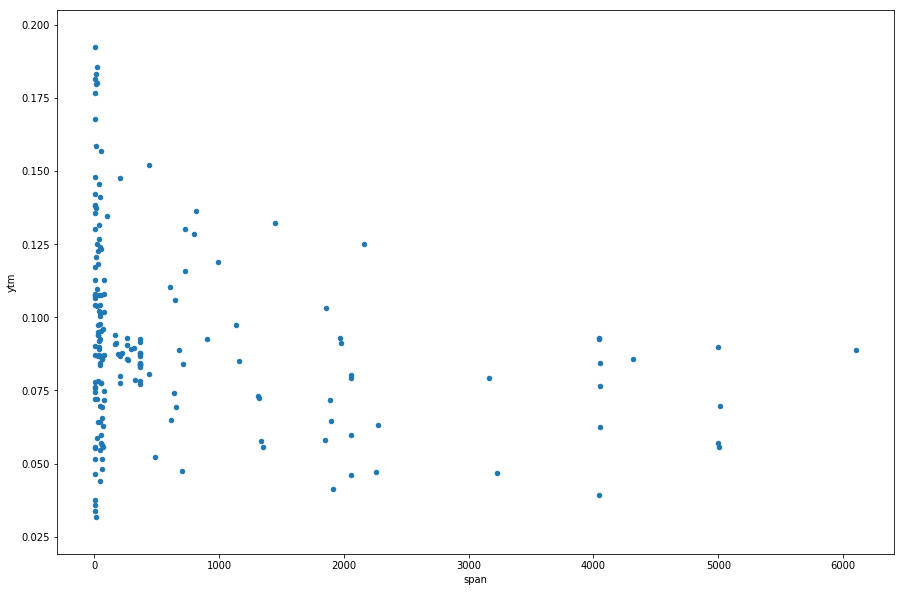

In [11]:
filtered_data.plot.scatter(x='span', y='ytm', figsize=(15, 10));

<center> Setting Loss arguments and optimization parameters

In [12]:
#Initial guess vector(for optimization)
x0 = [0.09, -0.01, 0, 0.5]#[0.85, -0.03, 0, 1.5]#[0.09, -0.01, 0, 1.5]
ytm_max = filtered_data['ytm'].max() 
#Parameters constraints
constr = ({'type':'ineq',
           'fun': lambda x: np.array(x[0] + x[1])})
#Longest matuiry year of deals in data
teta_cap = 6
max_deal_span = (filtered_data.span / 365).round().max()
#Parameters bounds for constraint optimization
bounds = ((0, 1), (None, None), (None, None), (1 / 12, teta_cap))
#Maturity limit for Zero-curve plot
longest_maturity_year = max([max_deal_span, 30])
theor_maturities = np.linspace(0.001, longest_maturity_year, 10000)
options = {'maxiter': 150, 'disp': True}
#Tuple of arguments for loss function            
loss_args = (filtered_data, coupons_cf, streak_data, CONFIG.RHO, CONFIG.WEIGHT_SCHEME)

Looking on weights

In [13]:
colors = (filtered_data.bond_maturity_type
          .astype('str')
          .map(dict(
               zip(filtered_data['bond_maturity_type'].astype('str').unique(), 
                    ['r', 'b', 'g']))
              )
         )

In [14]:
filtered_data['weight'] = weight(x0, filtered_data, weight_scheme=CONFIG.WEIGHT_SCHEME)

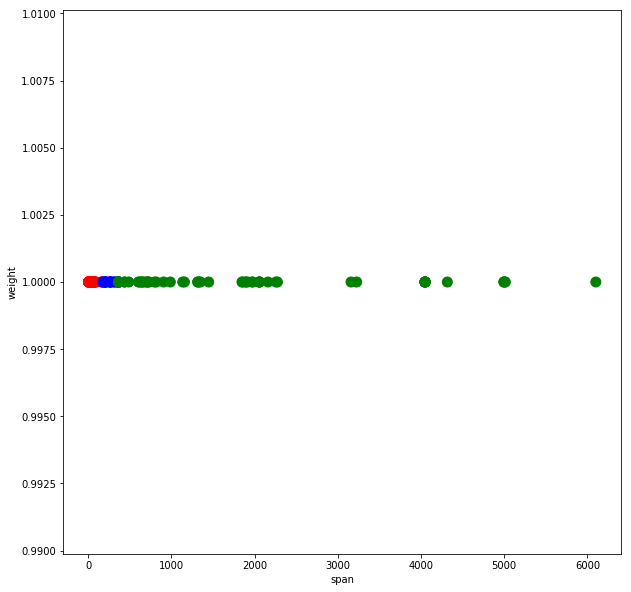

In [15]:
filtered_data.plot.scatter(x='span', y='weight', figsize=(10, 10), 
                           s=1e2, c=colors, legend=True,)

### Optimization

# 4 variable minimization

In [16]:
%%time
res_ = iter_minimizer(Loss=yield_Loss, beta_init=x0, 
                loss_args=loss_args, method='SLSQP', bounds=bounds,
                max_deal_span=max_deal_span, options=options)
#constraints=constr,
                      

[1.         3.08945552 0.08610387 0.49827844] 229439.2630330125
[ 2.91433544e-16  1.79207591e-01 -3.73793511e-01  5.01084562e-01] 1.4057832061900164
[0.00566318 0.07443703 0.24774742 0.49620126] 0.29608427450808117
[ 0.07447254  0.02319714 -0.0036469   0.49947682] 0.1795651709261156
[ 0.07447254  0.02319714 -0.0036469   0.49947682] 0.1795651709261156
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.1795651709261156
            Iterations: 5
            Function evaluations: 35
            Gradient evaluations: 5
Wall time: 38.7 s


In [17]:
beta_best = res_.x
beta_best#beta_best = np.array([0.08

array([ 0.07447254,  0.02319714, -0.0036469 ,  0.49947682])

In [18]:
ind = filtered_data.index
price_hat = (D(streak_data[ind], beta_best) * coupons_cf[ind]).sum().as_matrix()

In [19]:
#PRICE
mean_absolute_error(filtered_data.stand_price, price_hat)

2.3629869982522194

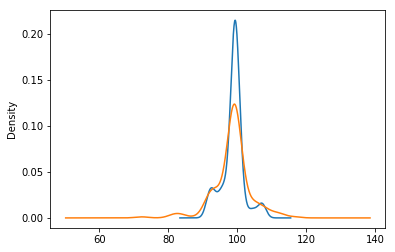

In [20]:
filtered_data.stand_price.plot(kind='kde')
filtered_data['price_hat'] = price_hat
filtered_data.price_hat.plot(kind='kde')

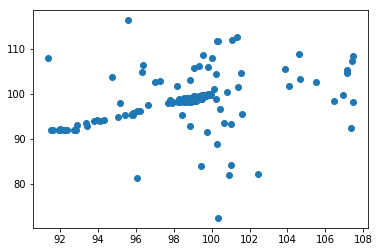

In [21]:
plt.plot(filtered_data.stand_price, price_hat, ls='', marker='o')

Finding min Loss path

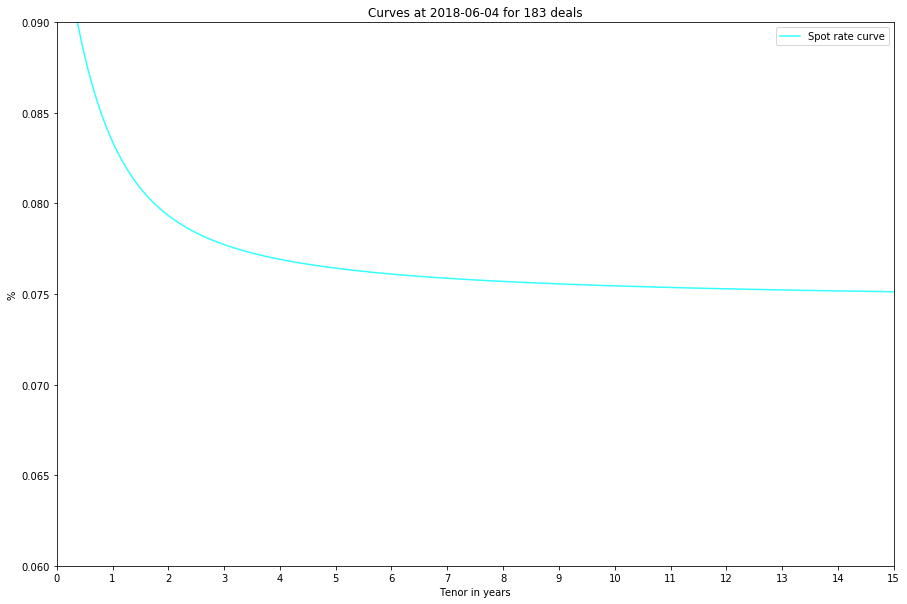

In [23]:
draw(beta_best, filtered_data, theor_maturities, CONFIG.SETTLE_DATE, 
     longest_maturity_year, draw_points=False, 
     weight_scheme='no_weight', label='Spot rate curve',
     color='cyan', alpha=0.8, shift=False)
plt.ylim(0.06, 0.09);
plt.xlim(0, 15)
plt.savefig(os.path.join(PATH, f'zero_curve_{CONFIG.SETTLE_DATE}.png'), dpi=400);

In [24]:
maturities_excel = np.array([7, 14, 30, 90, 180, 270, 365, 730, 1095, 
                    1825, 2555, 3650, 5475, 7300, 9125, 10950], dtype=int)

# Grid Search

In [27]:
tau_grid = np.append(np.arange(0.5, 1, 0.1), np.arange(2, teta_cap, 1.5))
beta_init = [0.85, -0.03, 0]

In [28]:
bounds_3var = bounds[:-1]
grid = grid_search(tau_grid=tau_grid, Loss=yield_Loss, 
                   loss_args=loss_args, beta_init=beta_init)

In [29]:
%%time
beta_best, loss_frame = grid.fit(options=options, return_frame=True, 
         method='SLSQP', num_workers=8, bounds=bounds_3var, constraints=constr) 

Wall time: 2min 55s


In [30]:
beta_best

array([ 0.074411  ,  0.02326708, -0.00364572,  0.5       ])

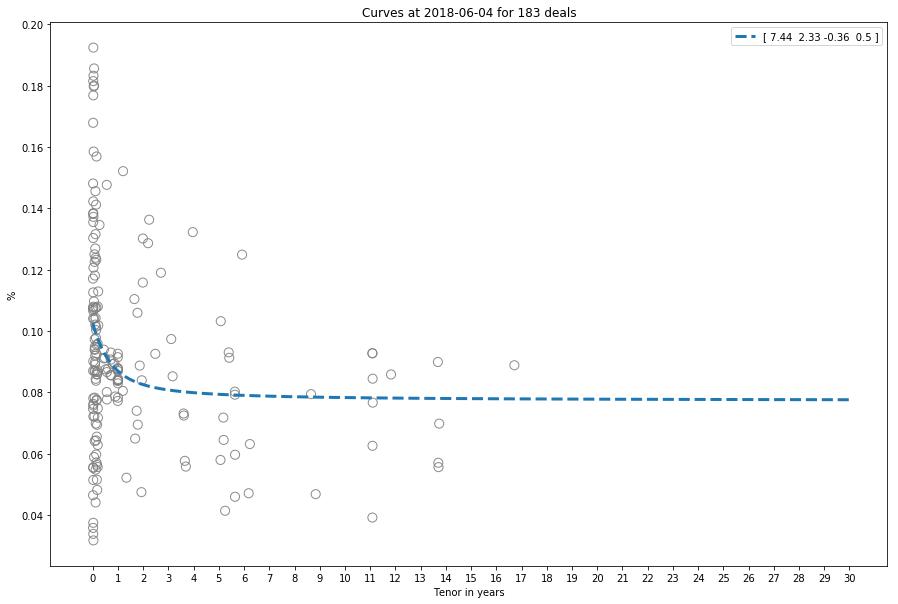

In [32]:
fig, ax = plt.subplots(figsize=(15, 10))
draw(beta_best, filtered_data, theor_maturities,  title_date=CONFIG.SETTLE_DATE, 
    longest_maturity_year=longest_maturity_year, draw_points=True,
    weight_scheme=CONFIG.WEIGHT_SCHEME, ax=ax, ls='--', linewidth=3, shift=True)

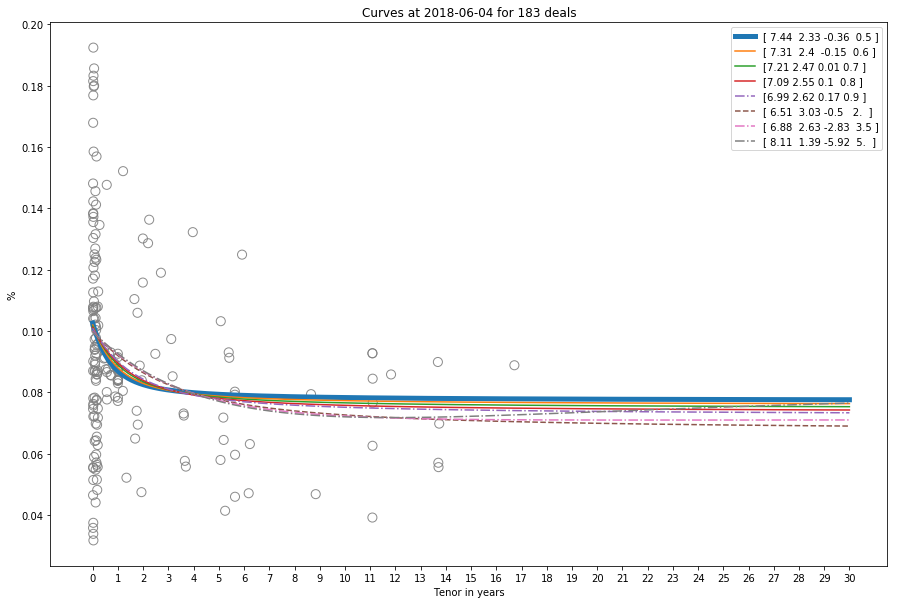

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))
linestyles = ['-', '--', '-.']
np.random.seed(111)
ls = np.random.choice(linestyles, size=loss_frame.shape[0])
for i, beta_ in enumerate(loss_frame.iloc[:, :-1].as_matrix()):
    ls_ = ls[i]
    if (beta_ == beta_best).all():
        draw(beta_, filtered_data, theor_maturities,  title_date=CONFIG.SETTLE_DATE, 
         longest_maturity_year=longest_maturity_year, draw_points=True,
         weight_scheme=CONFIG.WEIGHT_SCHEME, ax=ax, ls=ls_, linewidth=5, shift=True)
    else:
        draw(beta_, filtered_data, theor_maturities, shift=True,
             title_date=CONFIG.SETTLE_DATE, longest_maturity_year=longest_maturity_year, 
             weight_scheme=CONFIG.WEIGHT_SCHEME, draw_points=False, ax=ax, ls=ls_)

ax.legend(loc='upper right')

### Exctracting data

In [38]:
maturities = np.array([7, 14, 30, 90, 180, 270, 365, 2 * 365, 
                       3 * 365, 5 * 365, 7 * 365, 10 * 365, 
                       15 * 365, 20 * 365, 25 * 365, 30 * 365])

In [40]:
curves_data = curves_to_excel(f'curves_beta_{CONFIG.SETTLE_DATE}.xlsx', 
                              beta_best, 
                              settle_date=CONFIG.SETTLE_DATE, maturities=maturities)

In [41]:
payment_calendar_to_excel('coupons.xlsx', coupons_cf, streak_data)

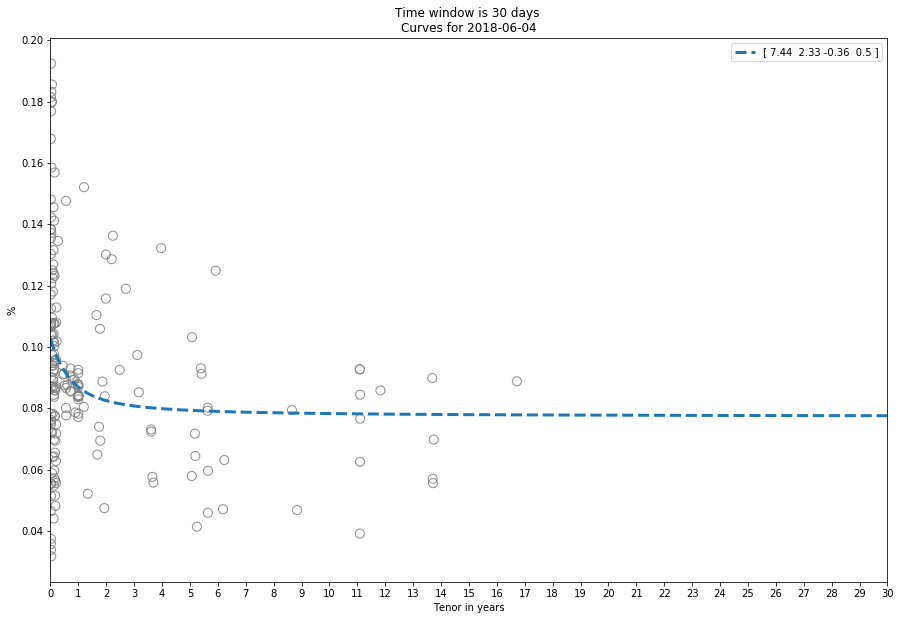

In [43]:
path_curve = os.path.join(PATH, f'{loss.__name__}_{CONFIG.SETTLE_DATE}.pdf')
with PdfPages(path_curve) as pdf:
    draw(beta_best, filtered_data, theor_maturities,  title_date=CONFIG.SETTLE_DATE, 
         longest_maturity_year=longest_maturity_year, draw_points=True,
         weight_scheme=CONFIG.WEIGHT_SCHEME, ls='--', linewidth=3, shift=True)
    pdf.savefig()
plt.title(f'Time window is {CONFIG.TIME_WINDOW} days \n'
          f'Curves for {CONFIG.SETTLE_DATE}')
plt.xlim(0, longest_maturity_year);